In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# A Reinforcement Learning toy problem - visualized

Here, we study a typical toy problem that's often used for introductory courses. An actor finds herself in an environment represented by a board - a 2-dimensional grid. The fields in that grid can have different characteristics, and in our case the characteristic is given by the reward $R$ associated with each field. We have regular fields with a small negative reward, meant to encourage the actor to look for the shortest path, and we have fields that come with great reward or great penalties. You'll see a graphical representation of that field in a minute, don't worry.


---

### State and environment
We have a stationary environment, so state is well-defined by position and directions of the actor.

In [354]:
class Board():
    """
    Just an intuitively indexed array
    """
    def __init__(self, array):
        self.array = np.array(array)
        self.width = np.shape(array)[1]
        self.height = np.shape(array)[0]
        
    def get(self, x,y):
        return self.array[self.height-y-1][x]
    
    def set(self, x,y,v):
        self.array[self.height-y-1][x] = v
        
    def __repr__(self):
        return str(self.array)

In [460]:
class State1:
    def __init__(self, environment, position, direction = [0, 0]):
        self.env = environment
        self.pos = np.array(position)
        self.d = direction
                
    def options(self): 
        """
        All actions that lead to fields with valid rewards
        """
        return [a[0]
            for a in Move.actions(include_none=False).items()
            if not np.isnan(self.env.reward_at(self.pos+a[1]))]

    def is_done(self):
        return self.env.is_done(self.pos)
    
    def go(self, dir):
        new_pos = self.pos + dir
        if new_pos[0] < 0 or new_pos[0] >= self.env.right \
            or new_pos[1] < 0 or  new_pos[1] >= self.env.top:
            new_dir = [0,0]
            new_pos = self.pos
            return State1(self.env, new_pos, new_dir)
 
        if np.isnan(self.env.board.get(*new_pos)):
            new_dir=[0, 0]
            new_pos = self.pos
        else:
            new_dir = dir
            self.env.vf_matrix.set(new_pos[0], new_pos[1], 
                                   self.env.bellmann(new_pos))
        return State1(self.env, new_pos, new_dir)
        
        
    def show(self):
        """
        Display this state in the context of its environment.
        State refers to an Environment, but the environment doesn't know this state.
        """
        self.env.show(self)
        
    def __repr__(self):
        return "Pos: %s, Dir: %s" % (self.pos, self.d)

In [537]:
class Environment:
    def __init__(self, array, gamma=0.9):
        self.board = Board(array)
        self.top=np.shape(array)[0]
        self.right=np.shape(array)[1]
        self.gamma = gamma
        self.vf_matrix=Board(np.zeros(np.shape(array)))
    
    def show(self, state):
        import seaborn as sns

        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))        
        
        # The board itself as a heat map
        axes = sns.heatmap(self.board.array, annot=True, 
                           cmap='bwr_r', ax=ax1, cbar=False)
        axes.set_xticks([], [])
        axes.set_yticks([], [])
        
        # The actor's position
        axes.plot([state.pos[0]+0.5], [self.top-state.pos[1]-0.5], 
                  'go', markersize=30)
        
        # the actor's direction
        l = np.max([np.sqrt(state.d[0]**2 + state.d[1]**2), 1])
        d = 0.4/l
        axes.plot([state.pos[0]+0.5+d*state.d[0]], 
                  [self.top-state.pos[1]-0.5-d*state.d[1]], 
                  'go', markersize=15)

        # the value function's heat map
        axes = sns.heatmap(self.vf_matrix.array, 
                           annot=True, cmap='bwr_r', ax=ax2)
        axes.set_xticks([], [])
        axes.set_yticks([], [])

        return ""

  
    def bellmann(self, pos):
        """
        The new value according to the bellmann equation
        """
        return np.max([
            self.reward_at(np.array(pos)+Move.actions()[a]) + 
            self.gamma * self.vf_matrix.get(*(np.array(pos) + Move.actions()[a]))
            for a in State1(env, pos).options()])      


    def reward_at(self, pos):
        if pos[0] < 0 or pos[0] >= self.right or pos[1] < 0 or pos[1] >= self.top:
            return np.nan
        if np.isnan(self.board.get(*pos)):
            return np.nan
        else:
            return self.board.get(*pos)
    

    def success(self, pos):
        return self.reward_at(pos) == 1
       
    def failure(self, pos):
        return self.reward_at(pos) == -1
  
    def is_done(self, pos):
        return self.failure(pos) or self.success(pos)

    def clear_vf(self):
        self.vf_matrix=Board(np.zeros((self.top, self.right)))    

In [538]:
board = np.array([[-0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01],
       [-0.01, -0.01, -0.01, -0.01, -0.01, np.nan, -0.01],
       [-0.01, -0.01, np.nan, -0.01, -0.01, -0.01, -1],
       [-0.01, -0.01, -0.01, -0.01, -0.01, -0.01, 1],
       [-0.01, np.nan, -0.01, -0.01, -1, -0.01, -0.01]])

env = Environment(board)
np.shape(board)

(5, 7)

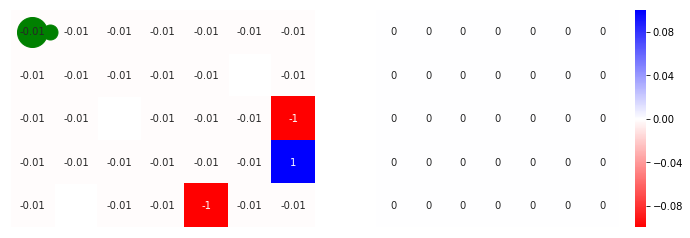

In [539]:
state = State1(env,  [0,4], [1, 0])
state.show()

The grey areas are *forbidden*. The State class will simply ignore moves onto those fields - just as well as it will ignore moves that would lead beyond the limits of the board.

The state is considered done when the reward is either $1$ or $-1$

In [540]:
state.options()

['s', 'e', 'se']

In [541]:
env.reward_at([6,2])

-1.0

In [542]:
state.is_done()

False

In [543]:
env.bellmann([5,1])

1.0

---
### Deterministic Moves
Here, a deterministic move is an action in the terminology of Reinforcement Learning. A deterministic move takes a state and returns a new one, namely the particular state where the actor has moved into the given direction. We'll introduce states hereafter. Moves can go into the 8 typical directions, with the 'none' move as a nineth option to not move at all.
We modelled moves as classes with a ```__call__()``` method to be able to actually apply a move to a state and return the state - the board - with the actor now sitting on a field adjacent to the previously occupied field.

We can already play around with the Moves without knowing the board - the state - yet. Noticed the use of complex numbers for rotation? Cool stuff, huh?

In [544]:
class Move:
    @staticmethod
    def actions(include_none=False):
        all = {
            's': [0,-1], 'w': [-1,0], 'n': [0,1], 'e':[1,0],
            'ne': [1,1], 'nw': [-1,1], 'se': [1,-1], 'sw': [-1, -1]}
        if include_none:
            all['none'] = [0,0]
        return all
    
    @staticmethod
    def compare(d1, d2):
        return np.sign(d1[0]*d2[0] + d1[1]*d2[1])


In [545]:
class DMove(Move):
    "Deterministic action"
  
    def __init__(self, dir):
        self.R=1-1j
        self.L=1+1j
        self.dir = Move.actions(include_none=True)[dir] if type(dir)==str else dir
    
    def __call__(self, state):
        return state.go(self.dir)
    
    def compare(self, other):
        """
        basically the sign of the inner product
        """
        return np.sign(self.dir[0]*other.dir[0] + self.dir[1]*other.dir[1])
  
    def rot_left(self, n=1):
        return self.rot(self.L, n)
  
    def rot_right(self, n=1):
        return self.rot(self.R, n)
  
    def rot(self, A, n=1):
        D= complex(self.dir[0], self.dir[1])
        once = DMove([np.sign(np.real(A*D)), np.sign(np.imag(A*D))])
        return once if n==1 else once.rot(A, n-1)

    def __repr__(self):
        return str(self.dir)

In [546]:
south = DMove('s')
south, south.rot_left() # from south to south-east.

([0, -1], [1.0, -1.0])

```compare()``` returns $1$ if the moves are somewhat parallel - $0$, if they're perpendicular and $-1$ if they're somewhat antiparallel. We'll use that feature to make the agents moves less *unmotivated*. We want her to avoid going back after she'd made a step into a certain direction. This behaviour will be encoded into her  policy $p(s,a)$ 

In [547]:
south.compare(south.rot_left(3))

-1.0

In [548]:
s, se, e, w = [DMove(i) for i in ['s', 'se', 'e', 'w']]

In [549]:
print(state)
print(e(state))
print(w(state))

Pos: [0 4], Dir: [1, 0]
Pos: [1 4], Dir: [1, 0]
Pos: [0 4], Dir: [0, 0]


In [550]:
state.options()
#env.bellmann([6,1])

['s', 'e', 'se']

Pos: [6 1], Dir: [1, -1]


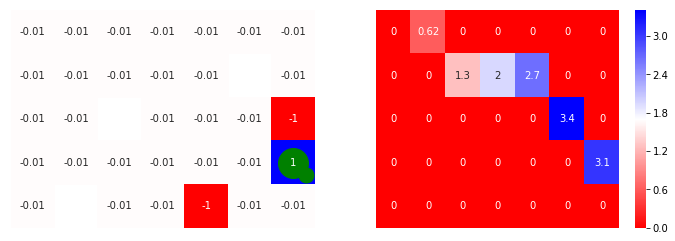

In [555]:
s1 = se(se(e(e(se(e(state)))))) # Moving on to the maximum reward
print(s1)
s1.show()

In [556]:
s1.is_done()

True

---
### The policy

In [557]:
class Policy_epsilon_off:
    """      
    This policy prefers the max reward, but allows epsilon probability for 
    each non-max-expecting action in the direction of the previous move
    """
    def __init__(self, epsilon=.1):
        self.epsilon = epsilon
    
    def __call__(self, s, include_none=False):
        # Look at the neighbours
        environ = { a[0]: s.env.reward_at(s.pos+a[1]) 
                   for a in Move.actions(include_none).items()}

        # omit those going somewhat backwards
        environ={a[0]: a[1] if Move.compare(DMove(a[0]).dir, s.d) >= 0 else np.nan 
                 for a in environ.items()} 
        return self.policy(environ)
  
  
    def policy(self, environ):
        # The number of possible directions
        lenr = len([i[1] for i in environ.items() if not np.isnan(i[1])])

        # The max return (maybe multiple)
        maxr = np.max([i[1] for i in environ.items() if not np.isnan(i[1])])

        # The number of values equal to the max
        lenm = len([i[1] for i in environ.items() 
                    if not np.isnan(i[1]) and i[1]==maxr])

        pmax = (1 - (lenr-lenm) * self.epsilon) / lenm

        return { i[0]: pmax if i[1] == maxr else .1
                if not np.isnan(i[1]) else 0 
                for i in environ.items()}
  
  
    def draw(self, s, include_none=False):
        """
        Choose an action according to the given epsilon-greedy distribution
        """
        d = self.__call__(s, include_none)
        keys = ['s', 'w', 'e', 'n', 'se', 'ne', 'sw', 'nw']
        if include_none:
            keys.append('none')
        values = np.cumsum([ d[k] for k in keys])
        values = np.insert(values, 0,0)
        index = np.digitize(np.random.uniform(), values)-1
        return keys[index]

In [558]:
p = Policy_epsilon_off(.1)
p(state)

{'e': 0.3333333333333333,
 'n': 0,
 'ne': 0,
 'nw': 0,
 's': 0.3333333333333333,
 'se': 0.3333333333333333,
 'sw': 0,
 'w': 0}

Our policy provides a distribution for choosing the next action somewhat *not-so-greedy*. It avoids going back. Observe that the last move below is going east, so our policy omits all options that have an western component. 

In [559]:
p = Policy_epsilon_off(.1)
e, w = [DMove(i) for i in ['e', 'w']]
s1 = e(w(w(s1)))
p(s1)

{'e': 0.6, 'n': 0.1, 'ne': 0.1, 'nw': 0, 's': 0.1, 'se': 0.1, 'sw': 0, 'w': 0}

You can see the policy in action if you draw from the distribution that it establishes:

In [560]:
p = Policy_epsilon_off(.1)
bins={'none': 0, 'n': 0, 'e': 0, 's': 0, 'w': 0, 'ne': 0, 'se': 0, 'sw': 0, 'nw': 0}
for i in range(10000):
  bins[p.draw(s1, include_none=False)]+=1
bins

{'e': 5960,
 'n': 985,
 'ne': 989,
 'none': 0,
 'nw': 0,
 's': 1049,
 'se': 1017,
 'sw': 0,
 'w': 0}

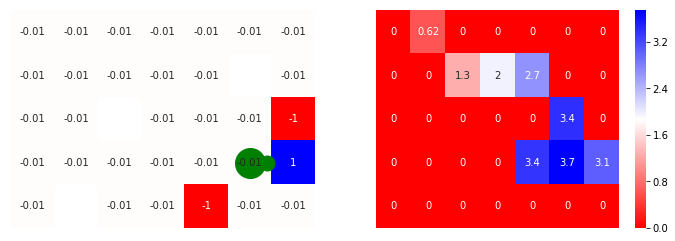

In [561]:
s1.show()

---
### Bellmann equation for deterministic environments

$$
V(s)=\text{max}_a(R(s,a) + \gamma \cdot V(a(s))
$$

Note that the value of a state does not depend on the current policy. 

From finance talk: Check the following (out of curiosity)

- Hurst exponents
- strange attractors
- Problem: markets change, so models will always be off-guard
- Black-Scholes learned by RL (paper!)
- Dynamich Replication and Hedging A Reinforcement Learning Approach
- Inverse RL: Find the utility function $v(s)$
- Watch: Alpha-go: The movie
- paper: Inverse Reinforcement Learning for Marketing
- Book: Big Data and ML in Quantitative Investment: Tony Guida